<a href="https://colab.research.google.com/github/hideaki-kyutech/syseng2025/blob/main/queueing2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# システム工学: 第11回 待ち行列2


## 課題: 顧客満足度を保ちながら、窓口運営コストを最小化するには？
### 背景
あるサービス施設は、1つの窓口で対応しており、顧客は平均1分あたり0.9人($\lambda=0.9$)の割合で到着する。この施設では、以下の2つの要件を同時に満たしたい。
- 顧客の平均待ち時間$W_q$ を5分以内に抑える
- 窓口の運営コストをなるべく下げたい（=高すぎるサービス率は避けたい）

#### [課題1]
$\mu$(サービス率)を1.0〜1.5の範囲で変化させながら、
- シミュレーションを実行し
- 各$\mu$における平均待ち時間$W_q$を記録せよ。
- 理論値との比較も行い、シミュレーション精度を確認せよ。

#### [課題2]
- 要件「平均待ち時間が5分以内」を満たす最小のサービス率$\mu$を見つけよ。

#### [課題3]
- $\mu$を上げると窓口職員のコストが増えると仮定し、コスト関数
$Cost(\mu) = 1000+300(\mu-1.0)^2$
を導入する
- 「待ち時間5分以下」と「コスト最小化」の両立を目指し、最適な$\mu$を決定せよ。

## インストール

In [ ]:
!pip install japanize-matplotlib # グラフ中で日本語表記を可能にするライブラリのインストール

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 36.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bd2e3fbcf1b196f982a14cd4088c1b5535cc45a392b7df48a10c6eb671d06a4e
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


## インポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

## [1] ポアソン到着と指数サービスの生成
「$1$分あたり$0.9$人（$0.9$人/分）で到着する」ことは、言い換えると「$1$人到着するのに$1/0.9$分（$1/0.9$ 分/人）時間がかかる」ことと同じである。$0.9$や$1/0.9$は平均値であり、実際の到着人数や到着間隔は確率的に変動する。この確率的な変動を再現するために、到着人数はポアソン分布、到着間隔は指数分布に従って生成する。


###[小問1] 到着率$\lambda =0.9$のとき、到着間隔`arrival_interval`を指数分布に従う乱数として1つ生成してください。
ヒント：指数分布に従う乱数を生成する関数`np.random.exponential(scale=` $\beta$ `)` ($\beta$は指数分布の平均値)を用いる。

In [ ]:
arrival_interval = np.random.exponential(scale=1/0.9)
print(arrival_interval)

0.595660858885666


### [小問2] $N=10$人の顧客の到着時刻列 `arrival_times` を生成してください。
ヒント1: `np.random.exponential(scale=` $\beta$ `, size=` $N$ `)`とすることで、$N$個の指数分布に従う乱数列をリストとして生成できる。

ヒント2: `a=[1, 2, 3]`の時、`b=np.cumsum(a)`により、`b=[1, 3, 6]`となる

In [ ]:
N=10000
arrival_intervals = np.random.exponential(scale=1/0.9, size=N)
arrival_times = np.cumsum(arrival_intervals)
#print(arrival_times)

### [小問3] サービス率$\mu=1.2$のとき、$N=10$人分のサービス時間列 `service_times` を生成してください。
ヒント: サービス率とは単位時間あたりにサービスできる人数であり、この問題の文脈では単位は[人/分]となる。


In [ ]:
service_times = np.random.exponential(scale=1/1.0, size=N)
#print(service_times)

## [2] 開始時刻・終了時刻・待ち時間の計算

### [小問4] 最初の顧客のサービス開始時刻`start_times[0]`は到着時刻`arrival_times[0]`と等しいとし、サービス終了時刻`end_times[0]`を計算してください。
ヒント: `start_times`や`end_times`は要素数$N$のリストになると想定できるので、まず、`np.zeros(N)`で要素が全て$0$のリストを作成した後に、代入操作を行いましょう。

In [ ]:
start_times = np.zeros(N)
end_times = np.zeros(N)
start_times[0] = arrival_times[0]
end_times[0] = start_times[0] + service_times[0]
#print(end_times[0])

### [小問5] 2人目以降について、以下のルールで`start_times[i]`と`end_times[i]`を計算してください。
- 顧客`i`のサービス開始時刻は「到着時刻または前の終了時刻の遅い方」
- 終了時刻は開始時刻+サービス時間

ヒント: `for`文で計算しましょう。

In [ ]:
for i in range(1, N):
    start_times[i] = max(arrival_times[i], end_times[i-1])
    end_times[i] = start_times[i] + service_times[i]

#print(start_times)
#print(end_times)

### [小問6] 待ち時間列(各顧客の待ち時間のリスト) `wait_times` を計算してください。
ヒント: 各顧客の待ち時間はサービス開始時刻と到着時刻の差

In [ ]:
wait_times = start_times - arrival_times
#print(wait_times)

## [3] 平均待ち時間と理論値の比較

### [小問7] シミュレーションによる平均待ち時間 `simulated_Wq` を求めて出力してください。（少数第２位まで）
ヒント: リスト `a=[1,2,3]` の平均は `np.mean(a)`で計算できます。

In [ ]:
simulated_Wq = np.mean(wait_times)
print(f"Simulated Wq = {simulated_Wq:.2f}")

Simulated Wq = 7.57


### [小問8] 理論的平均待ち時間 $W_q^t$ を求めて小数点第２位まで出力してください。（$\lambda=0.9, \mu=1.0$）
ヒント: 利用率 $\rho=\frac{\lambda}{\mu}$とすると、$W_q^t=\frac{\rho}{\mu*(1-\rho)}$で算出できます。

In [ ]:
lambda_rate, mu = 0.9, 1.0
rho = lambda_rate / mu
theoretical_Wq = rho / (mu * (1 - rho))
print(f"Theoretical Wq = {theoretical_Wq:.2f}")

Theoretical Wq = 9.00


## [4] 可視化と設計問題

### [小問9] 待ち時間を折れ線グラフで表示してください。
- ヒント1: `plt.plot(x)`でリストxの折れ線グラフを表示できます。
- ヒント2: `plt.xlabel("Xlabel")`で、横軸のラベルを「Xlabel」に設定できます。
- ヒント3: `plt.ylabel("Ylabel")`で、縦軸のラベルを「Ylabel」に設定できます。
- ヒント4: `plt.title("Title")`で、グラフの題名を「Title」に設定できます。
- ヒント5: `plt.grid()`で、グラフ内に一定間隔のグリッド線を表示する設定にできます。
- ヒント6: `plt.show()`で、グラフを画面に表示します。

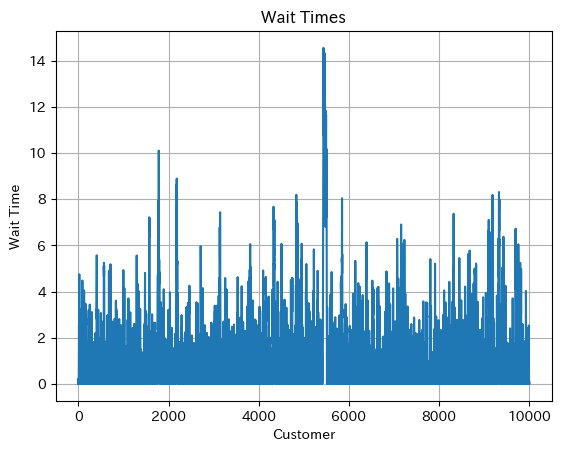

In [ ]:
plt.plot(wait_times[:10000])
plt.xlabel("Customer")
plt.ylabel("Wait Time")
plt.title("Wait Times")
plt.grid()
plt.show()

### [小問10] $\mu$ を$1.0$〜$1.5$まで$0.05$刻みで変えたときのシミュレーション平均待ち時間`Wqs_sim`をリストで記録してください。同様に理論的平均待ち時間`Wqs_the`もリストで記録してください。
- ヒント1: 設定する$\mu$のリストを`mu_values=np.arange(1.0, 1.51, 0.01)`で生成しましょう。
- ヒント2: `for`文で`mu_values`の各要素を順番にピックアップしましょう。
- ヒント3: 最初に`Wqs = []`で空リストを作成しておき、各$\mu$での平均待ち時間$W_q(\mu)$が計算できたら、`Wqs.append(` $W_q(\mu)$ `)`でリストに追加します。

In [ ]:
mu_values = np.arange(1.0, 1.51, 0.01)
Wqs_sim = []
Wqs_the = []
for mu in mu_values:
    service_times = np.random.exponential(scale=1/mu, size=N)
    start_times[0] = arrival_times[0]
    end_times[0] = start_times[0] + service_times[0]
    for i in range(1, N):
        start_times[i] = max(arrival_times[i], end_times[i-1])
        end_times[i] = start_times[i] + service_times[i]
    wait_times = start_times - arrival_times
    Wqs_sim.append(np.mean(wait_times))

    lambda_rate = 0.9
    rho = lambda_rate / mu
    theoretical_Wq = rho / (mu * (1 - rho))
    Wqs_the.append(theoretical_Wq)


### [小問11] $\mu$毎の平均待ち時間`Wqs`をグラフで可視化してください。
ヒント: 横軸を`mu_values`、縦軸を`Wqs`として、折れ線グラフを描くには`plt.plot(mu_values, Wqs, marker='o')`を設定します。

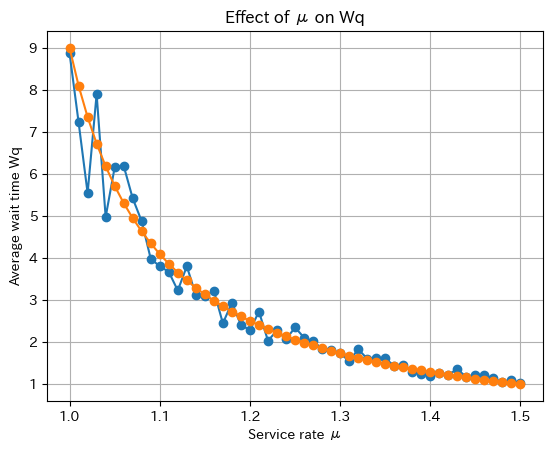

In [ ]:
plt.plot(mu_values, Wqs_sim, marker='o')
plt.plot(mu_values, Wqs_the, marker='o')
plt.xlabel("Service rate μ")
plt.ylabel("Average wait time Wq")
plt.title("Effect of μ on Wq")
plt.grid()
plt.show()

### [小問12] $W_q$が5分以下となる最小の$\mu$を求めてください。

In [ ]:
for mu, wq in zip(mu_values, Wqs):
    if wq <= 5:
        print(f"μ = {mu:.1f} gives Wq = {wq:.2f}")
        break

μ = 1.1 gives Wq = 4.54


### [小問13] 「待ち時間5分以下」を満たす$\mu$の中で最小コストとなる$\mu$を求めてください。また、その時の平均待ち時間を求めてください。
- $Cost(\mu) = 1000+300(\mu-1.0)^2$

In [ ]:
def cost_function(mu):
    return 1000 + 300 * (mu - 1.0)**2

total_costs = []
for mu, wait in zip(mu_list, Wqs):
    if wait <= 5:
        cost = cost_function(mu)
    else:
        cost = np.inf  # 不適合なら除外
    total_costs.append(cost)

# 最小コストを探す
min_index = np.argmin(total_costs)
optimal_mu = mu_list[min_index]
optimal_cost = total_costs[min_index]
optimal_wait = sim_waits[min_index]

print(f"最適なμ：{optimal_mu:.2f}")
print(f"対応する平均待ち時間：{optimal_wait:.2f}分")
print(f"対応するコスト　　　：{optimal_cost:.2f}円")

最適なμ：1.35
対応する平均待ち時間：1.50分
対応するコスト　　　：1036.75円
